In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Don't forget to add the current directory to pythonpath before loading the package
# $ export PYTHONPATH=$PYTHONPATH:$(pwd)
# & jupyter notebook
from aphp import load

# Qualité des données

20000 lignes

Pourcentage de valeurs manquantes (brutes)

    ```
    patient_id        0.000
    given_name        2.200
    surname           2.125
    street_number     1.910
    address_1         3.980
    suburb            1.060
    postcode          0.995
    state             9.950
    date_of_birth    10.055
    age              19.985
    phone_number      4.595
    address_2        60.535
    ```
    
    
### `patient_id`

- toutes les lignes ont un id
- cet id n'est pas unique: 403 lignes en doublon
- ces doublons de patient_id correspondent à des patients différents (nom, adresse, etc.)
- puisqu'il est impossible de choisir à quel patient correspond effectivement l'id, on est contraint de supprimer
  toutes ces lignes ambigües
  
  
### `date_of_birth` & `age`

- les deux colonnes sont des float
- % de données manquantes
    
    ```
    date_of_birth    10.055
    age              19.985
    ```
    
- la distribution des ages semble cohérente avec une situation réelle
    - il est cependant surprenant qu'elle ne concerne **presque personne de plus de 40 ans**
    
- la colonne `date_of_birth` ne peux pas être complètement exploitée
    - par exemple, avec `19950326.0`, on voudrait interpréter le format YYYYMMDD (donc ici 26 Mars 1995)
    - la distribution des 4 derniers chiffre semble bien correspondre à un mois puis à un jour du mois
    - la distribution des 4 premiers chiffre **ne correspond probablement pas à l'année de naissance**. En effet
      cette distribution est uniforme entre 1900 et 2000. Même en imaginant que 1915 correspond en fait à 2015, le
      fait que la distribution ne représente pas une pyramide des ages pose problème. **On choisit donc d'ignorer ces
      quatre premiers chiffres**
      
- on choisit de conserver l'information de mois et jour de naissance qui nous servira peut être à
  identifier des doublons. Il faudra néanmoins supprimer les valeurs impossible (ex: jour > 31).
  On peut éventuellement reconstruire une date de naissance en utilisant l'age
  
  
  
### `given_name` & `surname`

- % de valeur manquantes:

    ```
    given_name        2.200
    surname           2.125
    ```
    
- il y a quelques noms et prénoms très courts (2 lettres) mais il est difficile pour moi de savoir s'il
  s'agit de saisie incomplète ou de réels noms
  

Doublons:

- on trouve 4867 entrées pour lesquelles le nom + prénom est doublonné
- certains noms sont courants:

    ```
    emiily white           14
    emiily green           12
    joshua white           11
    joshua campbell        11
    william white          10
    ...
    ```
    
- en regardant ces doublons de noms / prénoms, il semble facile de lever l'ambiguité
  à partir par exemple du numéro de téléphone ou de la date d'anniversaire calculée plus tôt
  
     - dans le cas d'un réel doublon, le **`patient_id` est différent**. Il faudra donc surement prendre
        en compte l'ensemble des ids associés à une seule personne lors de la jointure avec les tests PCR.
  
  
- on repère bien sûr des erreurs de saisie dans les noms complets, par exemple (distance de Levenshtein de 1):

    ```
    1407442 	abbey coleman 	1 	1 	abby coleman 	3 	1
    7111441 	abbey gree 	1 	1 	abbey green 	3 	1
    1138007 	abby gerafhty 	1 	1 	abby geraghty 	3 	1
    6110331 	adam schumajnn 	1 	1 	adam schumann 	3 	1
    8087473 	alans reid 	1 	1 	alana reid 	3 	1
    6928743 	alec white 	1 	1 	alex white 	3 	1
    8037304 	alivia white 	1 	1 	olivia white 	4 	1
    2612086 	amalia webb 	1 	1 	amelia webb 	3 	1
    ...
    ```

### `state`

- 10% de valeurs manquantes
- quelques valeurs erronnées que l'on remplace par des valeurs manquantes, on ne conserve que les 8 états:

    ```
    {
        'nsw': 'New South Wales',
        'vic': 'Victoria',
        'qld': 'Queensland',
        'wa': 'Western Australia',
        'sa': 'South Australia',
        'tas': 'Tasmania',
        'act': 'Australian Capital Territory',
        'nt': 'Northern Territory',
    }
    ```


### `phone_number`

- 4.6% de valeurs manquantes
- tous les numéros ont 11 charactères (y compris un espace) et sont correctement formatés
- il ne semble pas y avoir de numéro aberrant (type 00 0000000)
- les numéros sont répartis équitablement sur les différents indicatifs

    ```
    02 Geographic: Central East region (NSW, ACT)
    03 Geographic: South-east region (VIC, TAS)
    04 Digital Mobile services (3G, 4G, 5G and GSM)
    07 Geographic: North-east region (QLD)
    08 Geographic: Central and West region (SA, NT, WA)
    ```
    
- en regardant les numéros de téléphone en doublon, j'ai l'impression qu'il s'agit toujours de la même personne.
  Je n'ai pas trouvé par exemple le cas d'un parent et d'un enfant avec le même numéro de téléphone.
- par contre, cela permet de se rendre compte de la non-qualité de saisie des données, par exemple sur les typos
  dans les noms / prénoms, l'inversion entre le nom et le prénom, des erreurs sur l'age...
  
  
### `postcode`

- 1% de valeurs manquantes
- additionnellement, 14 lignes pour lesquelles le format 'dddd' n'est pas respecté (nom de ville à la place)
- certains codes postaux qui sont beaucoup plus représentés (~100 lignes)

In [3]:
df = load.load_raw_patients()
df.tail()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
19995,368617,abby,None,19.0,john cleland crescent,boyne island,2290,nsw,19570210.0,NaN,02 92489054,glenmore
19996,796658,dale,priest,19.0,bellchambers crescent,hoppers crossing,3033,wa,19590619.0,31.0,07 20549476,None
19997,511885,alessia,mawlai,4.0,miller street,smithfield,3616,tas,NaN,26.0,03 83466737,None
19998,985932,hannah,mason,1.0,halligan place,beaumaris,2443,wa,19140304.0,25.0,04 41125514,None
19999,925217,jack,mcveigh,5.0,alinda place,thornlands,4350,nsw,19230521.0,26.0,07 52535106,None


In [4]:
len(df)

20000

In [5]:
# fraction of NaN values
(df.isnull().mean() * 100)

patient_id        0.000
given_name        2.200
surname           2.125
street_number     1.910
address_1         3.980
suburb            1.060
postcode          0.995
state             9.950
date_of_birth    10.055
age              19.985
phone_number      4.595
address_2        60.535
dtype: float64

In [6]:
# statistical summary of numeric columns
# we can immediatly see a discrepency between date of birth and age
df.describe().astype(int)

,patient_id,street_number,date_of_birth,age
count,20000,19618,17989,16003
mean,553918,98,19496375,27
std,260234,2481,292691,7
min,100005,0,12900410,0
25%,330194,10,19241129,24
50%,556327,24,19500321,29
75%,779419,60,19750519,33
max,999993,342951,19991229,92


In [7]:
# patient_id is not unique
df.nunique()

patient_id       19798
given_name        1171
surname           4273
street_number      834
address_1         4326
suburb            2925
postcode          2021
state              102
date_of_birth    13654
age                 58
phone_number     17916
address_2         3460
dtype: int64

### `patient_id`

- toutes les lignes ont un id
- cet id n'est pas unique
- des doublons de patient_id correspondent à des patients différents (nom, adresse, etc.)
- puisqu'il est impossible de choisir à quel patient correspond effectivement l'id, on est contraint de supprimer
  toutes ces lignes ambigües
  

In [8]:
import pandas as pd
pd.set_option('min_rows', 20)

df.loc[df.duplicated(subset=['patient_id'], keep=False)].sort_values(by='patient_id')

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
12117,109304,zachary,farronato,30.0,outtrim avenue,como,2196,vic,19090801.0,31.0,07 22894061,the reefs
14839,109304,bailey,donaldson,20.0,tardent street,ryde,0812,qld,19580310.0,26.0,07 13479210,None
4386,110207,toby,brock,4.0,merriman crescent,baralaba,3025,nsw,19000424.0,35.0,08 33842007,leitrim
12989,110207,zali,brock,32.0,hedger street,toorak,5038,act,NaN,22.0,08 96818512,None
10184,115791,hannah,clarke,70.0,galmarra street,mayfield,7010,vic,19830828.0,25.0,04 70760611,None
19629,115791,marley,colquhoun,7.0,boolee street,craigie,2534,qld,19000705.0,NaN,04 59547776,None
13660,116375,isabella,None,6.0,gosse street,hawthorn,2620,nsw,19050713.0,26.0,None,None
17986,116375,emiily,piorkowski,12.0,cowper street,peakhurst,6027,None,19821018.0,28.0,04 79403053,None
1456,119816,jed,rollins,63.0,mauldon street,macquarie fields,4169,nsw,19010805.0,NaN,07 73786737,None
2377,119816,sam,iasenzaniro,12.0,booroondara street,brighton,6153,sa,19621207.0,NaN,03 90915909,None


In [9]:
df.loc[df.duplicated(subset=['patient_id', 'surname'], keep=False)].sort_values(by='patient_id')

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
4386,110207,toby,brock,4.0,merriman crescent,baralaba,3025,nsw,19000424.0,35.0,08 33842007,leitrim
12989,110207,zali,brock,32.0,hedger street,toorak,5038,act,NaN,22.0,08 96818512,None


### `date_of_birth` & `age`

- les deux colonnes sont des float
- % de données manquantes
    
    ```
    date_of_birth    10.055
    age              19.985
    ```
    
- la distribution des ages semble cohérente avec une situation réelle
    - il est cependant surprenant qu'elle ne concerne **presque personne de plus de 40 ans**
    
- la colonne `date_of_birth` ne peux pas être complètement exploitée
    - par exemple, avec `19950326.0`, on voudrait interpréter le format YYYYMMDD (donc ici 26 Mars 1995)
    - la distribution des 4 derniers chiffre semble bien correspondre à un mois puis à un jour du mois
    - la distribution des 4 premiers chiffre **ne correspond probablement pas à l'année de naissance**. En effet
      cette distribution est uniforme entre 1900 et 2000. Même en imaginant que 1915 correspond en fait à 2015, le
      fait que la distribution ne représente pas une pyramide des ages pose problème. **On choisit donc d'ignorer ces
      quatre premiers chiffres**
      
- on choisit de conserver l'information de mois et jour de naissance qui nous servira peut être à
  identifier des doublons. Il faudra néanmoins supprimer les valeurs impossible (ex: jour > 31).
  On peut reconstruire une date de naissance en utilisant l'age

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

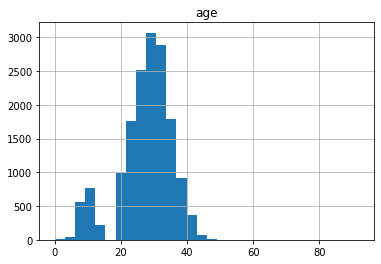

In [10]:
df.hist(column='age', bins=30)

In [11]:
df['age'].describe()

count    16003.000000
mean        27.534337
std          7.807008
min          0.000000
25%         24.000000
50%         29.000000
75%         33.000000
max         92.000000
Name: age, dtype: float64

<AxesSubplot:>

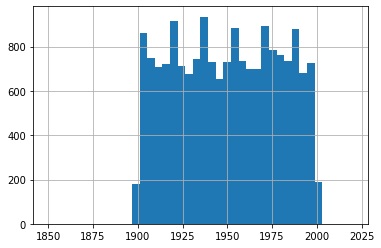

In [12]:
# characters 0 to 4 are probably not a year
(
    df['date_of_birth']
    .dropna()
    .astype(int)
    .astype(str)
    .str.slice(0, 4)
    .astype(int)
).hist(bins=40, range=(1850, 2020))

<AxesSubplot:>

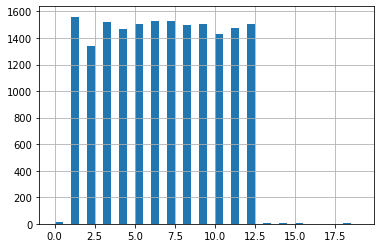

In [13]:
# characters 4 to 6 seem to match a month
(
    df['date_of_birth']
    .dropna()
    .astype(int)
    .astype(str)
    .str.slice(4, 6)
    .astype(int)
).hist(bins=range(20), width=0.5)

<AxesSubplot:>

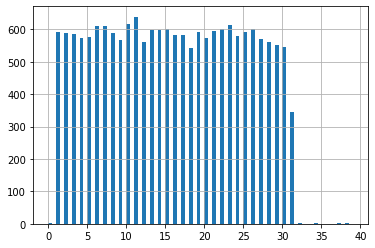

In [14]:
# characters 6 to 8 seem to match a day of the month
(
    df['date_of_birth']
    .dropna()
    .astype(int)
    .astype(str)
    .str.slice(6, 8)
    .astype(int)
).hist(bins=range(40), width=0.5)

In [15]:
with_date = df['date_of_birth'].notnull()

df.loc[with_date, 'birthday'] = pd.to_datetime(
    df.loc[with_date, 'date_of_birth'].astype(int).astype(str),
    format='%Y%m%d',
    errors='coerce'
).astype(str).str.slice(5,10).replace('', pd.np.NaN)

df.head()

<ipython-input-15-e7a7de94e9f4>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  ).astype(str).str.slice(5,10).replace('', pd.np.NaN)


,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella,07-08
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown,09-21
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None,09-05
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane,08-09
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None,04-30


In [16]:
df.isnull().mean() * 100

patient_id        0.000
given_name        2.200
surname           2.125
street_number     1.910
address_1         3.980
suburb            1.060
postcode          0.995
state             9.950
date_of_birth    10.055
age              19.985
phone_number      4.595
address_2        60.535
birthday         10.925
dtype: float64

### `given_name` & `surname`

- % de valeur manquantes:

    ```
    given_name        2.200
    surname           2.125
    ```
    
- il y a quelques noms et prénoms très courts (2 lettres) mais il est difficile pour moi de savoir s'il
  s'agit de saisie incomplète ou de réels noms
  
- il ne semble pas y avoir de problème d'inversion entre le nom et le prénom

Doublons:

- on trouve 4867 entrées pour lesquelles le nom + prénom est doublonné
- certains noms sont courants:

    ```
    emiily white           14
    emiily green           12
    joshua white           11
    joshua campbell        11
    william white          10
    ...
    ```
    
- en regardant ces doublons de noms / prénoms, il semble facile de lever l'ambiguité
  à partir par exemple du numéro de téléphone ou de la date d'anniversaire calculée plus tôt
  
     - dans le cas d'un réel doublon, le **`patient_id` est différent**. Il faudra donc surement prendre
        en compte l'ensemble des ids associés à une seule personne lors de la jointure avec les tests PCR.
  
  
- on repère bien sûr des erreurs de saisie dans les noms complets, par exemple (distance de Levenshtein de 1):


    ```
    1407442 	abbey coleman 	1 	1 	abby coleman 	3 	1
    7111441 	abbey gree 	1 	1 	abbey green 	3 	1
    1138007 	abby gerafhty 	1 	1 	abby geraghty 	3 	1
    6110331 	adam schumajnn 	1 	1 	adam schumann 	3 	1
    8087473 	alans reid 	1 	1 	alana reid 	3 	1
    6928743 	alec white 	1 	1 	alex white 	3 	1
    8037304 	alivia white 	1 	1 	olivia white 	4 	1
    2612086 	amalia webb 	1 	1 	amelia webb 	3 	1
    ...
    ```
    
    

In [17]:
temp = df.loc[:, ['given_name', 'surname']].copy()
temp['given_name_length'] = temp['given_name'].str.len()
temp['surname_length'] = temp['surname'].str.len()

temp.sort_values('given_name_length').head(20)

,given_name,surname,given_name_length,surname_length
10492,ka,wyllie,2.0,6.0
11309,ky,fargahry-tolba,2.0,14.0
7924,ka,sarossy,2.0,7.0
1611,ka,filipovic,2.0,9.0
4055,to,godfrey,2.0,7.0
18627,ki,campbell,2.0,8.0
14097,ty,mortlock,2.0,8.0
15123,ka,conaghty,2.0,8.0
929,ky,sonnack,2.0,7.0
8628,ka,mason,2.0,5.0


In [18]:
temp.dropna(subset=['given_name']).sort_values('given_name_length').tail(20)

,given_name,surname,given_name_length,surname_length
17813,jean-claude,gianakis,11.0,8.0
8150,konstantinos,crute,12.0,5.0
13931,taylor-saige,sykiotis,12.0,8.0
8445,taylor-saige,frahn,12.0,5.0
15199,taylor-saige,agius,12.0,5.0
2421,konstantinos,mccarthy,12.0,8.0
17550,taylor-saige,marshman,12.0,8.0
17889,konstantinos,carmody,12.0,7.0
442,lachlan-john,sherriff,12.0,8.0
8572,konstantinos,jessup,12.0,6.0


In [19]:
temp['given_name'].astype(str).value_counts()

nan            440
emiily         373
joshua         340
thomas         262
jack           260
lachlan        213
sophie         210
benjamin       208
william        205
isabella       194
              ... 
freyz            1
apriq            1
chritepher       1
chris            1
allie            1
chrisgopher      1
taloa            1
jte              1
dealin           1
isablela         1
Name: given_name, Length: 1172, dtype: int64

In [20]:
temp['surname'].astype(str).value_counts()

white          539
clarke         438
nan            425
green          398
ryan           315
campbell       312
reid           272
matthews       263
webb           252
nguyen         235
              ... 
pieterek         1
tschirn          1
dainton          1
valadares        1
tieppo           1
chambis          1
galffy           1
klingohr         1
werrey           1
tsoubarakis      1
Name: surname, Length: 4274, dtype: int64

In [21]:
temp.sort_values('surname_length').head(20)

,given_name,surname,given_name_length,surname_length
1941,lucy,h,4.0,1.0
12051,tristan,ho,7.0,2.0
3781,jesse,tu,5.0,2.0
2402,alana,co,5.0,2.0
10537,jassim,ma,6.0,2.0
3762,noah,ho,4.0,2.0
10013,sachin,au,6.0,2.0
7503,william,so,7.0,2.0
13788,cooper,ho,6.0,2.0
142,lushia,ho,6.0,2.0


In [22]:
temp.dropna(subset=['surname']).sort_values('surname_length').tail(20)

,given_name,surname,given_name_length,surname_length
10739,tara,bates-brownsword,4.0,16.0
77,beau,stanislaus-large,4.0,16.0
389,None,oolgaard-snijder,NaN,16.0
17970,finley,eckersley-maslin,6.0,16.0
13740,lachlan,henderson-wilson,7.0,16.0
8420,joshua,bates-brownsword,6.0,16.0
2555,cameron,wilson-haffenden,7.0,16.0
1077,noah,cuerden-clifford,4.0,16.0
8473,kayla,atkinson-crawford,5.0,17.0
6514,timothy,papazacharoudakis,7.0,17.0


<AxesSubplot:>

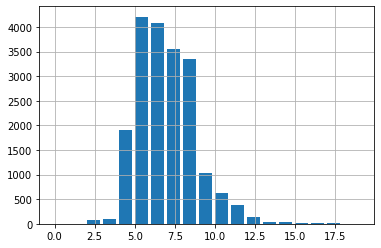

In [23]:
temp['surname_length'].hist(bins=range(20), width=0.8)

In [24]:
(temp['given_name'] + ' ' + temp['surname']).value_counts()

emiily white         14
emiily green         12
joshua white         11
joshua campbell      11
william white        10
emiily ryan          10
thomas webb           9
liam clarke           9
thomas white          9
emiily clarke         9
                     ..
blake rollins         1
william badewitz      1
bayley green          1
isabella ozog         1
lachlan staude        1
tabitha kotaro        1
daniel campain        1
jake clissold         1
mikhaili dunstone     1
amber weelius         1
Length: 16681, dtype: int64

In [25]:
(temp['given_name'] + ' ' + temp['surname']).duplicated(keep=False).sum()

4867

In [26]:
# no obvious issue of given_name - surname inversion
top_surnames = temp['surname'].value_counts().head(100)
temp.loc[temp['given_name'].isin(top_surnames.index)]

,given_name,surname,given_name_length,surname_length
94,blake,rollins,5.0,7.0
119,mason,thorpe,5.0,6.0
189,george,kerley,6.0,6.0
197,ryan,weaver,4.0,6.0
271,george,singleton,6.0,9.0
326,george,crouch,6.0,6.0
446,ryan,rabe,4.0,4.0
502,campbell,glouftsis,8.0,9.0
529,brock,mahony,5.0,6.0
592,matthews,ethn,8.0,4.0


In [27]:
(
    df
    .loc[df.duplicated(subset=['given_name', 'surname'], keep=False)]
    .sort_values(by=['given_name', 'surname'])
)

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
5498,524032,abbey,cadman,5.0,mugga ceay,burpengary,2545,None,19920592.0,29.0,03 45969923,None,NaN
16951,592646,abbey,cadman,5.0,mugga way,burpengary,2554,None,19920502.0,29.0,03 45996223,None,05-02
17258,593406,abbey,cadman,5.0,mugga way,burpengary,2545,None,19920502.0,29.0,03 45969923,None,05-02
16131,934038,abbey,campbell,48.0,coningham street,nowra,4401,vic,19211023.0,24.0,04 20572435,None,10-23
17538,549704,abbey,campbell,20.0,john cleland crescent,smithfield,2576,vic,NaN,33.0,03 13719531,st helens pastoral co,NaN
2781,959414,abbey,cropper,17.0,bowden crescent,ringwood,6237,qld,19200312.0,29.0,02 90211615,pangani,03-12
5089,560115,abbey,cropper,16.0,bowden crescent,ringwood,6231,qld,19200312.0,21.0,02 90211615,pangani,03-12
1190,932946,abbey,george,19.0,bainton crescent,underdale,3162,qld,19240105.0,21.0,08 64911039,None,01-05
14676,580579,abbey,george,97.0,bussau close,toorak,4650,nsw,19340416.0,NaN,03 16225795,None,04-16
6627,961858,abbey,green,5.0,wilkins street,ballina,6110,None,19040209.0,7.0,08 75306674,None,02-09


In [28]:
full_names = (temp['given_name'] + ' ' + temp['surname']).value_counts().reset_index().rename(columns={'index': 'name', 0: 'count'})
full_names['merge'] = 1
full_names = full_names.merge(full_names.loc[full_names['count'] > 2], on='merge')
full_names

,name_x,count_x,merge,name_y,count_y
0,emiily white,14,1,emiily white,14
1,emiily white,14,1,emiily green,12
2,emiily white,14,1,joshua white,11
3,emiily white,14,1,joshua campbell,11
4,emiily white,14,1,william white,10
5,emiily white,14,1,emiily ryan,10
6,emiily white,14,1,thomas webb,9
7,emiily white,14,1,liam clarke,9
8,emiily white,14,1,thomas white,9
9,emiily white,14,1,emiily clarke,9


In [29]:
! pip install python-Levenshtein

In [30]:
import Levenshtein

full_names['distance'] = full_names.apply(lambda r: Levenshtein.distance(r['name_x'], r['name_y']), axis=1)
full_names.head()

,name_x,count_x,merge,name_y,count_y,distance
0,emiily white,14,1,emiily white,14,0
1,emiily white,14,1,emiily green,12,5
2,emiily white,14,1,joshua white,11,6
3,emiily white,14,1,joshua campbell,11,13
4,emiily white,14,1,william white,10,6


In [31]:
full_names.loc[full_names['distance'] == 1].sort_values(by='name_x')

,name_x,count_x,merge,name_y,count_y,distance
1343987,abbey coleman,1,1,abby coleman,3,1
5671834,abbey gree,1,1,abbey green,3,1
4619885,abby gerafhty,1,1,abby geraghty,3,1
1102883,adam schumajnn,1,1,adam schumann,3,1
1533417,alans reid,1,1,alana reid,3,1
3620673,alec white,1,1,alex white,3,1
4933516,alivia white,1,1,olivia white,4,1
4290210,amalia webb,1,1,amelia webb,3,1
4456840,amber sape,1,1,amber slape,4,1
3753806,amy masoj,1,1,amy mason,5,1


In [32]:
full_names.loc[full_names['distance'] == 1]['count_x'].sum()

167

In [33]:
full_names.loc[full_names['distance'] == 2].sort_values(by='name_x')

,name_x,count_x,merge,name_y,count_y,distance
1716199,abbey nguyen,1,1,amber nguyen,3,2
2010484,abbey rees,1,1,abbey green,3,2
415092,abbey white,2,1,amber white,3,2
2050909,abbry gree,1,1,abbey green,3,2
714056,abby mason,2,1,amy mason,5,2
8148894,abby ryan,1,1,ruby ryan,3,2
2796384,abby white,1,1,toby white,3,2
2796644,abby white,1,1,amy white,3,2
740549,adam campbell,2,1,liam campbell,3,2
786982,adam clarke,2,1,liam clarke,9,2


In [34]:
df.loc[df['given_name'].isnull()]['surname'].isnull().mean()* 100

0.9090909090909091

In [35]:
df.loc[df['surname'].isnull()]['given_name'].isnull().mean()* 100

0.9411764705882352

### `state`

- 10% de valeurs manquantes
- quelques valeurs erronnées que l'on remplace par des valeurs manquantes

In [36]:
df['state'].isnull().mean() * 100

9.950000000000001

<AxesSubplot:>

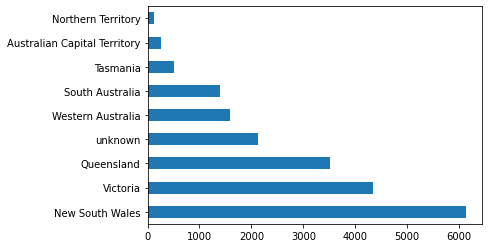

In [37]:
states = {
    'nsw': 'New South Wales',
    'vic': 'Victoria',
    'qld': 'Queensland',
    'wa': 'Western Australia',
    'sa': 'South Australia',
    'tas': 'Tasmania',
    'act': 'Australian Capital Territory',
    'nt': 'Northern Territory',
}

df['state'].map(states).fillna(value='unknown').value_counts().plot(kind='barh')

### `phone_number`

- 4.6% de valeurs manquantes
- tous les numéros ont 11 charactères (y compris un espace) et sont correctement formatés
- il ne semble pas y avoir de numéro aberrant (type 00 0000000)
- les numéros sont répartis équitablement sur les différents indicatifs

    ```
    02 Geographic: Central East region (NSW, ACT)
    03 Geographic: South-east region (VIC, TAS)
    04 Digital Mobile services (3G, 4G, 5G and GSM)
    07 Geographic: North-east region (QLD)
    08 Geographic: Central and West region (SA, NT, WA)
    ```
    
- en regardant les numéros de téléphone en doublon, j'ai l'impression qu'il s'agit toujours de la même personne.
  Je n'ai pas trouvé par exemple le cas d'un parent et d'un enfant avec le même numéro de téléphone.
- par contre, cela permet de se rendre compte de la non-qualité de saisie des données, par exemple sur les typos
  dans les noms / prénoms, l'inversion entre le nom et le prénom, des erreurs sur l'age...

In [38]:
df['phone_number'].isnull().mean() * 100

4.595

In [39]:
(df['phone_number'].dropna().str.match('\d{2} \d{8}') == False).sum()

0

In [40]:
df['phone_number'].value_counts()

03 49777256    4
03 71626498    4
07 00356561    4
08 65508869    4
08 61745219    4
07 31638236    4
03 74582010    4
03 01075733    4
02 57389153    4
03 55283892    4
              ..
03 09318642    1
02 40800373    1
04 23798515    1
08 37760617    1
07 42513164    1
07 32660330    1
03 67508255    1
07 02142628    1
08 67781961    1
08 78366153    1
Name: phone_number, Length: 17916, dtype: int64

<AxesSubplot:>

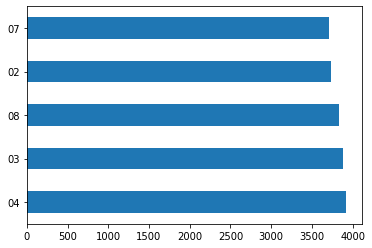

In [41]:
df['phone_number'].str.slice(0,2).value_counts().plot(kind='barh')

In [42]:
df.loc[df['phone_number'].isin(df['phone_number'].value_counts().head(10).index)].sort_values(by='phone_number')

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
8617,475348,luke,mercorella,16.0,gollan street,the entrance,2614,nsw,19630628.0,24.0,02 57389153,None,06-28
11464,492573,mercorella,luke,16.0,gollan street,the entrance,2614,nsw,19630628.0,24.0,02 57389153,brentwood vlge,06-28
6410,878776,luke,mercorella,15.0,gollan street,the entrance,2614,nsw,19606028.0,24.0,02 57389153,None,NaN
16070,436239,luke,mercofella,16.0,gollan street,tilbuster,2614,nsw,19630628.0,24.0,02 57389153,None,06-28
18632,744621,isabella,beddlng,18.0,heidelberg street,toowoomba,3764,nsw,19510108.0,NaN,03 01075733,laurel bank,01-08
11919,411372,isabella,bedding,17.0,heidelberg street,toowoomba,3764,nse,19510108.0,NaN,03 01075733,laurel bank,01-08
14731,130916,isabella,bedding,17.0,heidelberg street,toowoomba,3764,nsw,19510108.0,NaN,03 01075733,laurel bank,01-08
15575,572694,isabella,beddimg,17.0,heidelberg street,3764,toowoomba,nsw,19510108.0,NaN,03 01075733,laurel bank,01-08
10271,579498,isabella,virzu,33.0,somervilld street,killara,3616,vic,19970414.0,35.0,03 49777256,the villas north,04-14
12701,964302,isabella,virag,33.0,somerville street,killara,3616,vic,19970414.0,35.0,03 49777256,the villas north,04-14


In [43]:
phones = df['phone_number'].value_counts()
same_phone = phones[phones > 1]
same_phone

03 49777256    4
03 71626498    4
07 00356561    4
08 65508869    4
08 61745219    4
07 31638236    4
03 74582010    4
03 01075733    4
02 57389153    4
03 55283892    4
              ..
04 64486504    2
08 80628328    2
07 63533597    2
02 90393245    2
04 93625543    2
02 44451019    2
08 75079808    2
02 15230330    2
08 60989775    2
03 47256818    2
Name: phone_number, Length: 687, dtype: int64

In [44]:
df.loc[df['phone_number'].isin(same_phone.index) & (df['age'] < 15)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
124,803550,jake,george,5.0,burkitt street,paralowe,4551,nsw,NaN,12.0,04 75210574,the willows,NaN
129,113986,samuel,menzies,28.0,benny place,toronto,4555,None,19470209.0,10.0,07 21513738,oreel,02-09
140,894824,benjamin,seddon,113.0,monaro crescent,yunderup,4060,nsw,19050210.0,11.0,03 07007789,None,02-10
290,233883,tarnia,lengerink,29.0,bainton crescent,frankston,2161,None,NaN,9.0,07 36420755,None,NaN
301,577095,joshua,bellamly,41.0,namatjiracdrive,clayfield,4574,vc,19631211.0,10.0,03 61524567,None,12-11
382,271890,carlib,george,5.0,millard zlace,lennox head,2234,vic,19321222.0,12.0,08 02954691,None,12-22
448,156958,caitlin,riddell,14.0,carinassgreet,st albans,5059,qld,NaN,9.0,08 62513595,None,NaN
516,827975,nicholas,fitzpatrick,3429.0,taylor place,normanhurst,4560,nsw,19680530.0,11.0,08 37654995,None,05-30
538,844840,camefn,monjean,40.0,hicks steet,figtree,5108,vic,19750415.0,8.0,04 96506229,None,04-15
582,876665,madrlixe,beadell,117.0,groom street,wyoning,4218,nsw,19230525.0,7.0,08 81656149,None,05-25


In [45]:
df.loc[df['phone_number'] == '04 45973943']

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
16867,456043,gabriel,braunack,6.0,bouchard place,nelson,2224,None,19530730.0,9.0,04 45973943,None,07-30
19869,902744,gabriel,braunack,6.0,bouchard olace,nelsos,2224,None,19530730.0,9.0,04 45973943,None,07-30


### `postcode`

- 1% de valeurs manquantes
- additionnellement, 14 lignes pour lesquelles le format 'dddd' n'est pas respecté (nom de ville à la place).
  Je remarque que dans ce cas, le code postal a été rempli dans la colonne `suburb`
- certains codes postaux qui sont beaucoup plus représentés (~100 lignes)

In [46]:
df['postcode'].isnull().mean() * 100

0.9950000000000001

In [47]:
df['postcode'].value_counts()

4350    96
4670    82
4740    74
2250    71
2170    68
6210    63
4870    62
2148    59
3199    58
2145    58
        ..
2408     1
2806     1
3328     1
4422     1
4735     1
7209     1
5720     1
6466     1
4496     1
3467     1
Name: postcode, Length: 2021, dtype: int64

In [48]:
df.loc[(df['postcode'].str.match('\d{4}') == False)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,birthday
3976,810644,juliana,grosvenor,5.0,connelly pace,3023,port noarlunga south,tas,19991215.0,NaN,03 55227740,None,12-15
4080,986559,kirra,choi-lundberg,102.0,centaurus street,6168,naremburn,vic,19261104.0,27.0,08 69584599,None,11-04
5792,752873,lochlan,blake,258.0,None,4216,toowoobma,wa,19080821.0,31.0,02 84630666,None,08-21
6218,902348,isaac,nakoje,19.0,collier street,6017,brighton,None,19640421.0,8.0,02 69439226,None,04-21
6618,678110,jaden,green,5.0,dovey place,3185,oraneg,vic,19151204.0,23.0,02 73534391,None,12-04
9653,690348,andrew,ryan,20.0,mainwaring rich circuit,3020,blacktown,wa,19760001.0,22.0,None,None,NaN
9718,727290,tiffany,loukes,31.0,leal place,467l0,forest hill,nsw,19760706.0,23.0,None,pangani,07-06
11333,738103,hugi,pascoe,167.0,leita court,3023,port lincoln,nsw,19040401.0,NaN,07 84786511,None,04-01
14255,684359,sonia,green,50.0,kalgoorlie crescent,6112,ashfield,sa,NaN,9.0,03 46671647,None,NaN
15479,355033,abby,yoob,243.0,weston street,3181,forest hill,None,19660615.0,26.0,02 68667816,None,06-15
